## ANLP Assignment 1: Sentiment Analysis
### Arpan Mukhopadhyay,  a1797378

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from langdetect import detect
import json
import re
from collections import Counter, defaultdict
import string

### 1. Reading dataset and initial pre-processing

In [154]:
#Cleaning out the original test and train datasets 
def langFilter(file,type:str):
    num = 0
    with open(f"hotel_review_en_{type}.JSON", "w") as out_file:
        with open(file,"r") as in_file:
            lines = in_file.readlines()
            for line in lines:
                num += 1
                # if num%100==0: print(num)
                json_line = json.loads(line)
                try:
                    lang = detect(json_line["text"])
                    if lang == "en":
                        out_file.write(line)
                except:
                    print("exception")
                    pass

#uncomment to generate JSON train and test sets of only english texts
# langFilter("hotel_reviews_train.JSON","train")
# langFilter("hotel_reviews_test.JSON","test")

In [155]:
original_data = pd.read_json('hotel_reviews_train.JSON', lines=True)
train_data = pd.read_json("hotel_review_en_train.JSON", lines=True)

#checking to see the difference in reviews after removal of non english reviews
print(len(original_data))
print(len(train_data))

24000
23999


In [156]:
test_data = pd.read_json("hotel_review_en_test.JSON", lines=True)
print(len(test_data))

6000


In [157]:
train_data.columns

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile'],
      dtype='object')

In [158]:
train_data['title']

0                             “Horrible experience”
1                                       “Stay Away”
2                      “Great location and service”
3                “I will never go back here again!”
4        “Ripped off our VISA card after departure”
                            ...                    
23994            “pleasant stay with good location”
23995     “Hit or miss, some things need attention”
23996                              “Good breakfast”
23997                    “Deserves a higher rating”
23998                        “Clean & comfortable!”
Name: title, Length: 23999, dtype: object

In [159]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

In [160]:
#omitting lowercase for now
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]','',text)
        text = re.sub(r'[\n\r\t]', ' ',text)
        text = re.sub(r'\s+', ' ', text)
        text.translate(text.maketrans('', '', string.punctuation)) #added just as a final sanity check if stuff was missed
        return text.strip()
    return ""

train_data['clean_title'] = train_data['title'].apply(clean_text)
train_data['clean_text'] = train_data['text'].apply(clean_text)

test_data['clean_title'] = test_data['title'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

In [161]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

In [162]:
train_data['clean_text'][0]

'First of all we got there and they didnt have the room we booked did not pay us the difference from the room we booked to the cheaper one they gave us STAFF took forever to address our problem not KID friendly pool dirty and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY We thought by paying more we would get a good deal well this hotel is not the case 400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business They are giving SHERATON a horrible reputation I guess they are managed by SHERATON but have their own policies and undesirable customer service Great time in San Diego but a nightmare of a hotel Dont ever write reviews but this one was called for if you can avoid this hotel do it Being a military family and moving from state to state we know

### 2. Exploratory Data Analysis (EDA)

In [163]:
print(train_data.columns)
print(test_data.columns)

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')
Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')


In [164]:
train_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,Horrible experience,First of all we got there and they didnt have ...
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,Stay Away,Found Racist graffiti in the room Request to c...
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,Great location and service,Close to Union Square hotel is a bit of a maze...
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,I will never go back here again,I had a bad vibe about this place from the mom...
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,Ripped off our VISA card after departure,After we received our final bill and left the ...


In [165]:
missing_overall_rating = train_data[~train_data['ratings'].apply(lambda x: 'overall' in x)]
missing_overall_rating

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text


In [166]:
max_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).max()
mean_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).mean()
min_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review: {min_words} words", 
      f"\nAverage length of review: {round(mean_words,3)} words", 
      f"\nLongest review: {max_words} words")

Shortest review: 4 words 
Average length of review: 152.342 words 
Longest review: 2239 words


In [167]:
max_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).max()
mean_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).mean()
min_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review title: {min_title_length} words", 
      f"\nAverage length of review title: {round(mean_title_length ,3)} words", 
      f"\nLongest review title: {max_title_length} words")

Shortest review title: 0 words 
Average length of review title: 4.822 words 
Longest review title: 26 words


In [168]:
row_data = train_data.loc[train_data['clean_title'] == '']
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
2169,"{'service': 1.0, 'cleanliness': 5.0, 'overall'...","“!""”",We stayed in the W in Dallas twice. The first ...,"{'username': 'Chach63', 'num_cities': 15, 'num...",October 2011,600113,3,2012-07-06,133598143,False,,We stayed in the W in Dallas twice The first t...


In [169]:
# print(f"original title: {row_data['title'].iloc[0]},\ncleaned title: '{row_data['clean_title'].iloc[0]}' ")

In [170]:
row_data = train_data[train_data['clean_title'].str.split().str.len() == 1]
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
15,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Value”,"Doing an AM tour at Sony Studios, and the loca...","{'username': 'rwmentzer', 'num_cities': 16, 'n...",September 2012,248239,0,2012-09-28,141497337,False,Value,Doing an AM tour at Sony Studios and the locat...
26,"{'service': 5.0, 'cleanliness': 4.0, 'overall'...",“Fairmont-Dallas”,We had a most enjoyable short stay at this fin...,"{'username': 'Fred H', 'num_reviews': 1, 'id':...",October 2012,98606,0,2012-10-21,143365025,False,FairmontDallas,We had a most enjoyable short stay at this fin...
37,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Excellent”,We had the misfortune of getting standed in Sa...,"{'username': 'NorthLincsChikky', 'num_cities':...",November 2009,79985,1,2009-11-08,48753878,False,Excellent,We had the misfortune of getting standed in Sa...
70,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“wow”,"well, where to start? \nfirstly, the location,...","{'username': 'dexbrighton', 'num_cities': 2, '...",February 2007,93507,5,2007-02-19,6811836,False,wow,well where to start firstly the location that ...
85,"{'cleanliness': 5.0, 'value': 4.0, 'overall': ...",“Outstanding!”,Just back from a (2) day stay at the Omni. Aft...,"{'username': 'dje', 'num_cities': 10, 'num_hel...",May 2005,224948,7,2005-05-31,3514473,False,Outstanding,Just back from a 2 day stay at the Omni After ...
...,...,...,...,...,...,...,...,...,...,...,...,...
23799,{'overall': 2.0},“Sewage”,Unfortunately the room smelled like sewage. Ve...,"{'username': 'J W', 'num_reviews': 2, 'num_cit...",July 2012,87635,0,2012-07-20,134944668,False,Sewage,Unfortunately the room smelled like sewage Ver...
23806,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Exceptional”,In addition to it being about a three minute w...,"{'username': 'Layover', 'num_cities': 102, 'nu...",March 2009,1157456,1,2009-05-11,29788756,False,Exceptional,In addition to it being about a three minute w...
23820,"{'service': 2.0, 'cleanliness': 1.0, 'overall'...",“Horrible”,Room doors that look like coffin lids. Sea foa...,"{'username': 'spanlaketraveler', 'num_cities':...",December 2007,214197,2,2007-12-08,11326781,False,Horrible,Room doors that look like coffin lids Sea foam...
23954,"{'cleanliness': 1.0, 'overall': 1.0, 'rooms': ...",“Seedy”,I was surprised to learn from the other review...,"{'username': '', 'id': '', 'location': ''}",April 2005,100561,9,2005-04-08,3343889,False,Seedy,I was surprised to learn from the other review...


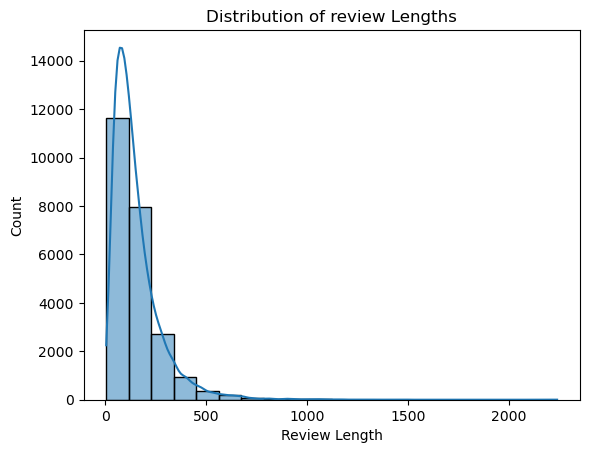

In [171]:
import seaborn as sns
train_data['text_length'] = train_data['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(train_data['text_length'], bins=20, kde=True)
plt.title('Distribution of review Lengths')
plt.xlabel('Review Length')
plt.show()

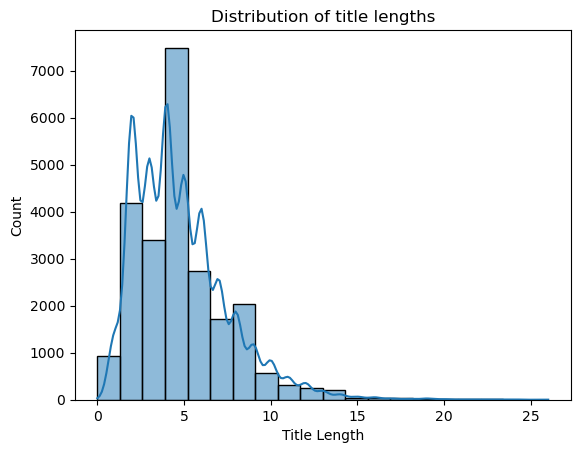

In [172]:
train_data['title_length'] = train_data['clean_title'].apply(lambda x: len(x.split()))
sns.histplot(train_data['title_length'], bins=20, kde=True)
plt.title('Distribution of title lengths')
plt.xlabel('Title Length')
plt.show()

[(5, 9824), (4, 7720), (3, 3287), (2, 1611), (1, 1557)]


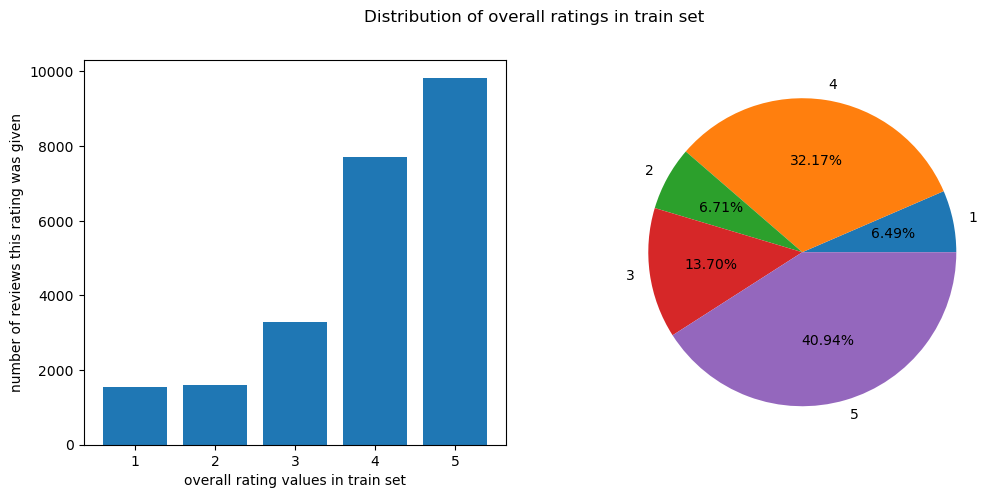

In [173]:
def overall_ratings_plot(data, type):
    ratings_distribution = []
    for i in range(len(data)):
        ratings_distribution.append(int(train_data['ratings'][i]['overall']))
    ratings_freq = Counter(ratings_distribution)
    print(sorted(ratings_freq.items(), key= lambda x:x[0], reverse=True))
    # total = sum(ratings_freq.values())
    # print(total)
    # print(f'{type} set ratings distribution:', ratings_freq)
    # ratios = [(val, round(cnt/total, 3)) for val, cnt in ratings_freq.items()]
    # print(f"percentage of dataset per rating: {sorted(ratios, key= lambda x:x[1], reverse = True)}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Distribution of overall ratings in {type} set')
    axes[0].bar(ratings_freq.keys(), ratings_freq.values())
    axes[0].set_xlabel(f'overall rating values in {type} set')
    axes[0].set_ylabel('number of reviews this rating was given')

    axes[1].pie (ratings_freq.values(), labels= ratings_freq.keys(), autopct='%1.2f%%')

overall_ratings_plot(train_data, 'train')

[(5, 2509), (4, 1888), (3, 828), (2, 408), (1, 367)]


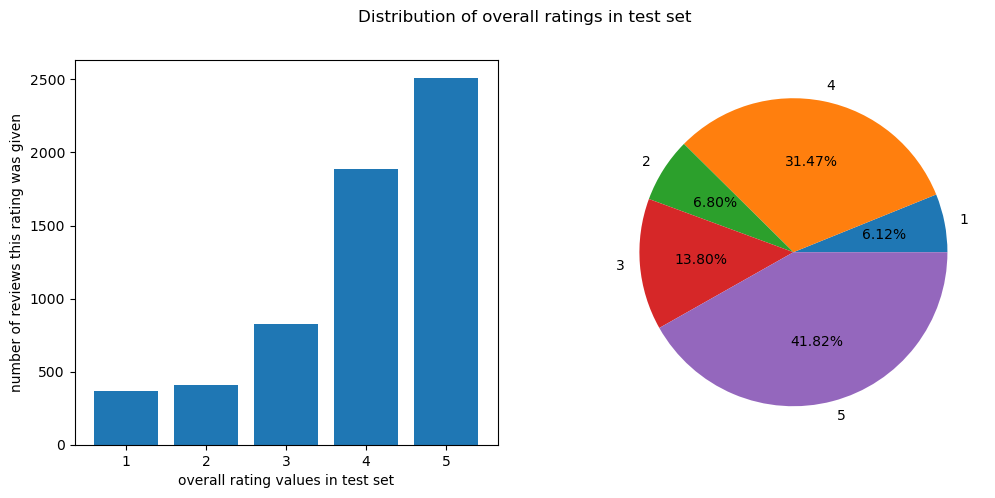

In [174]:
overall_ratings_plot(test_data, 'test')

In [175]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
train_data['stemmed_text'] = train_data['clean_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
train_data['stemmed_text']

0        first of all we got there and they didnt have ...
1        found racist graffiti in the room request to c...
2        close to union squar hotel is a bit of a maze ...
3        i had a bad vibe about thi place from the mome...
4        after we receiv our final bill and left the em...
                               ...                        
23994    we stay just one night here when visit our son...
23995    spent two night here with spous in conjunct wi...
23996    the room wa fairli larg pretti quiet the bed w...
23997    great start to our stay when we were check in ...
23998    great room comfort bed food is good the locat ...
Name: stemmed_text, Length: 23999, dtype: object

In [176]:
import spacy

nlp = spacy.load('en_core_web_sm')

#Noting: Lemmatization takes a while to run so running through pipe to speed it up (still takes ~2 mins)
def lemmatize(text):
    docs = list(nlp.pipe(text))
    return [' '.join([token.lemma_ for token in doc]) for doc in docs]

train_data['lemmatized_text'] = lemmatize(train_data['clean_text'])
train_data['lemmatized_text']

0        first of all we get there and they do not have...
1        find Racist graffiti in the room request to ch...
2        close to Union Square hotel be a bit of a maze...
3        I have a bad vibe about this place from the mo...
4        after we receive our final bill and leave the ...
                               ...                        
23994    we stay just one night here when visit our son...
23995    spend two night here with spouse in conjunctio...
23996    the room be fairly large pretty quiet the bed ...
23997    great start to our stay when we be check in 2h...
23998    great room comfortable bed food be good the lo...
Name: lemmatized_text, Length: 23999, dtype: object

In [177]:
a1 = train_data['stemmed_text'][4].split()
a2 = train_data['lemmatized_text'][4].split()
a3 = train_data['clean_text'][4].split()

print("Original Word | Stemmed Form | Lemmatized Form")
print("-" * 50)

for orig, stem, lemma in zip(a3, a1, a2):
    if stem != lemma:
        print(f"{orig:<13} | {stem:<12} | {lemma:<12}")


Original Word | Stemmed Form | Lemmatized Form
--------------------------------------------------
received      | receiv       | receive     
left          | left         | leave       
Empire        | empir        | Empire      
another       | anoth        | another     
charge        | charg        | charge      
accounting    | account      | accounting  
sent          | sent         | send        
justification | justif       | justification
response      | respons      | response    
company       | compani      | company     


using lemmatized text for further textual analysis as stemming can occasionally cut the actual word into its "stem" --> not very useful for model or eda

In [178]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['clean_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 62510
most frequent words use in reviews: [('the', 192545), ('and', 127800), ('a', 103769), ('to', 93843), ('was', 80158), ('I', 59749), ('in', 57570), ('of', 50150), ('The', 47904), ('is', 46002)]


In [179]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 62505


[('the', 192545),
 ('and', 127800),
 ('a', 103769),
 ('to', 93843),
 ('was', 80158),
 ('I', 59749),
 ('in', 57570),
 ('of', 50150),
 ('The', 47904),
 ('is', 46002)]

In [180]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 54072


[('the', 240655),
 ('be', 199451),
 ('and', 129430),
 ('a', 106050),
 ('to', 94381),
 ('I', 73297),
 ('we', 61408),
 ('in', 59098),
 ('of', 50357),
 ('room', 46906)]

In [181]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['lemmatized_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 54071
most frequent words use in reviews: [('the', 240655), ('be', 199451), ('and', 129430), ('a', 106050), ('to', 94381), ('I', 73297), ('we', 61408), ('in', 59098), ('of', 50357), ('room', 46906)]


In [182]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def most_common_words(N:list):
    most_frequent_actual_words = []

    for n in N:
        if n[0].lower() not in stop_words:
            most_frequent_actual_words.append(n)
        if len(most_frequent_actual_words) == 10:
            break

    return most_frequent_actual_words

most_frequent_actual_words = most_common_words(most_freq)
most_frequent_actual_words

[('room', 46906),
 ('hotel', 43971),
 ('stay', 29283),
 ('great', 15991),
 ('would', 14202),
 ('staff', 14182),
 ('get', 13934),
 ('good', 13909),
 ('night', 12544),
 ('nice', 11574)]

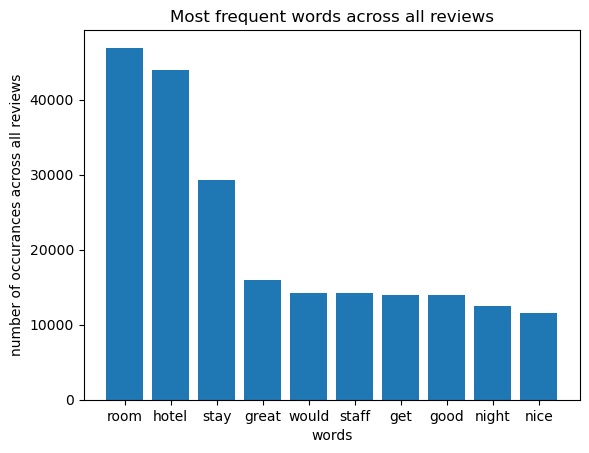

In [183]:
def plot_words(words, title_text, y_axis_text):
    words, counts = zip(*words)
    plt.bar(words, counts)
    plt.xlabel('words')
    plt.ylabel(y_axis_text)
    plt.title(title_text)

plot_words(most_frequent_actual_words,'Most frequent words across all reviews', 'number of occurances across all reviews')

In [184]:
def most_common_words_sentiment(N:list):
    negative_words = []
    positive_words = []
    for i in range(len(N)):
        data = word_tokenize(N['lemmatized_text'][i])
        rating = int(N['ratings'][i]['overall'])
        for w in data:
            if w.lower() in stop_words: continue
            if rating >= 2.5:
                positive_words.append(w)
            else:
                negative_words.append(w)
    
    return Counter(positive_words), Counter(negative_words)

positive_review_words, negative_review_words = most_common_words_sentiment(train_data)

print("Most common words in positive reviews: ")
positive_review_words.most_common(10)

Most common words in positive reviews: 


[('room', 37980),
 ('hotel', 37308),
 ('stay', 25099),
 ('great', 15312),
 ('staff', 12721),
 ('good', 12563),
 ('would', 11400),
 ('get', 11059),
 ('nice', 10615),
 ('night', 10108)]

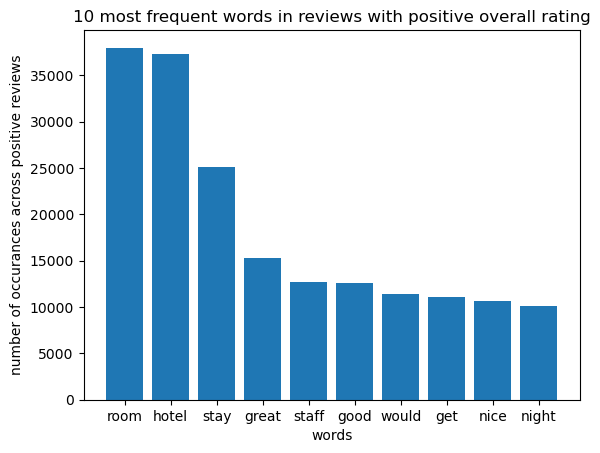

In [185]:
plot_words(positive_review_words.most_common(10),'10 most frequent words in reviews with positive overall rating', 'number of occurances across positive reviews')

In [186]:
print("Most common words in negative reviews:")
negative_review_words.most_common(10)

Most common words in negative reviews:


[('room', 8926),
 ('hotel', 6663),
 ('stay', 4184),
 ('get', 2875),
 ('would', 2802),
 ('night', 2436),
 ('one', 2234),
 ('go', 2135),
 ('say', 1694),
 ('could', 1663)]

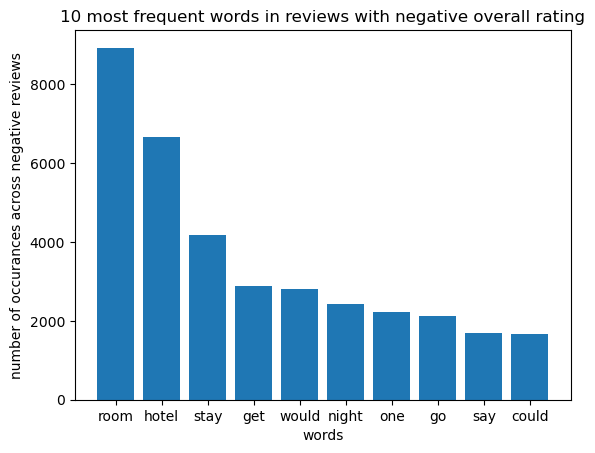

In [187]:
plot_words(negative_review_words.most_common(10),'10 most frequent words in reviews with negative overall rating', 'number of occurances across negative reviews')

In [188]:
from nltk import ngrams
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
The room was: 2943
the front desk: 2927
in the room: 2192
of the hotel: 2064
The hotel is: 2030
stay here again: 1696
stayed at the: 1606
at this hotel: 1601
the room was: 1563
one of the: 1483


In [189]:
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
the room be: 8638
the hotel be: 5439
the staff be: 4235
the front desk: 3637
stay at the: 3604
there be a: 3396
I do not: 2708
in the room: 2601
it be a: 2554
this hotel be: 2375


Not very useful. What if we look at the most common tri grams for both "positive" and negative reviews?


In [190]:
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
The room was: 2657
the front desk: 2047
The hotel is: 1894
of the hotel: 1777
in the room: 1680
stay here again: 1566
stayed at the: 1447
at this hotel: 1315
the room was: 1297
and it was: 1279


Most common 3-grams for negative rating reviews:
the front desk: 880
in the room: 512
of the hotel: 287
The room was: 286
at this hotel: 286
I had to: 267
the room was: 266
to the front: 223
we had to: 213
one of the: 209


In [191]:
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
the room be: 7601
the hotel be: 4880
the staff be: 3954
stay at the: 3201
there be a: 2936
the front desk: 2645
it be a: 2275
the location be: 2158
I do not: 2093
in the room: 2012


Most common 3-grams for negative rating reviews:
the room be: 1037
the front desk: 992
I do not: 615
in the room: 589
the hotel be: 559
there be no: 534
there be a: 460
stay at the: 403
this hotel be: 374
I have to: 343


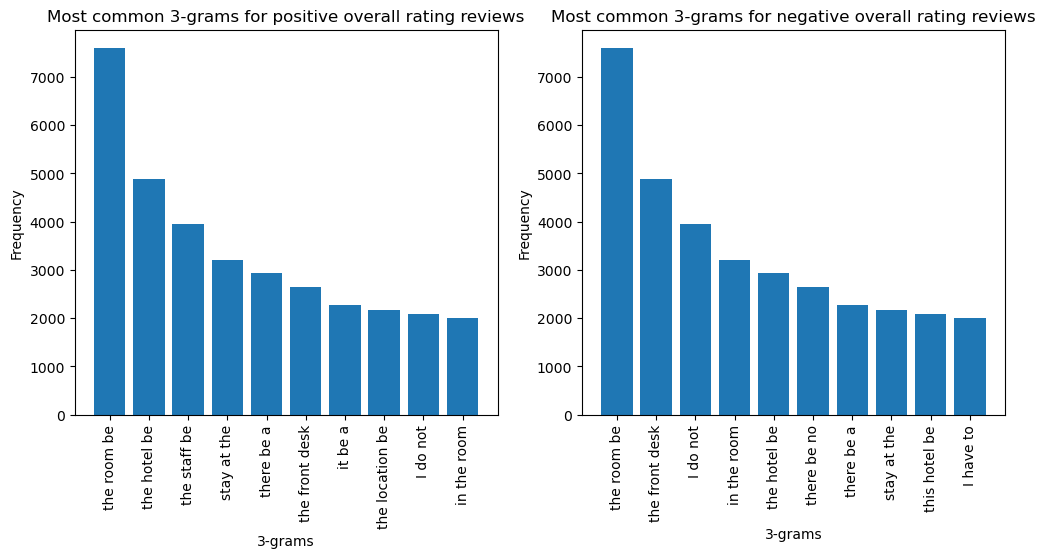

In [192]:
labels_pos, values_pos = zip(*positive_ngrams_freq.most_common(10))
labels_neg, values_neg = zip(*negative_ngrams_freq.most_common(10))
indexes = range(len(labels_pos))

lables = [labels_pos, labels_neg]
values = [values_pos, values_pos]

titles = [f"Most common {n}-grams for positive overall rating reviews", f"Most common {n}-grams for negative overall rating reviews"]
def multi_graph(indexes, labels, values, count, titles):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(count):
        axes[i].bar(indexes, values[i])
        axes[i].set_xlabel(f'{n}-grams')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xticks(indexes, labels[i], rotation='vertical')
        axes[i].set_title(titles[i])

multi_graph(indexes, lables, values, 2, titles)

In [193]:
titles = train_data['clean_title']
title_words = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        title_words.append(w.lower())

print(Counter(title_words).most_common(10))

[('great', 5981), ('hotel', 5185), ('location', 3992), ('the', 3191), ('a', 3067), ('and', 2669), ('stay', 2617), ('in', 2119), ('good', 2096), ('for', 1984)]


In [194]:
title_words_ns = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        if w.lower() not in stop_words:
            title_words_ns.append(w.lower())
            
print(Counter(title_words_ns).most_common(10))

[('great', 5981), ('hotel', 5185), ('location', 3992), ('stay', 2617), ('good', 2096), ('nice', 1662), ('service', 1402), ('staff', 1118), ('excellent', 1081), ('place', 1079)]


Based off all these experiments, it becomes apparent that some additional changes must be made to the data before being fed into a machine learning model. Given the consistant requirement of lowercasing the words for both the title and the text, all the text should be normalised through lowercasing. Though this might remove some of the "textual emotion" conveyed in some of the reviews as capital letters could indicate both excitement and anger. But also these are not terribly useful considering how similar the good and the bad reviews seem to be in terms of word similar. So rather than frequency or even n-gram maybe we need to look deeper

### 3. Selection and training Machine Learning models

In [195]:
train_data['lemmatized_text'] = train_data['lemmatized_text'].apply(lambda x: x.lower())
train_data['clean_title'] = train_data['clean_title'].apply(lambda x: x.lower())

In [196]:
train_data['clean_title'] = lemmatize(train_data['clean_title'])

In [197]:
def get_overall(ratings):
    try:
        return int(ratings.get('overall',None))
    except(AttributeError, TypeError):
        return None

train_data['overall'] = train_data['ratings'].apply(get_overall)
train_data['overall']

0        1
1        1
2        4
3        2
4        1
        ..
23994    4
23995    3
23996    5
23997    4
23998    5
Name: overall, Length: 23999, dtype: int64

In [198]:
lem_train_data = train_data[['overall', 'clean_title','lemmatized_text']]
stem_train_data =  train_data[['overall', 'clean_title','stemmed_text']]

In [199]:
lem_train_data

,overall,clean_title,lemmatized_text
0,1,horrible experience,first of all we get there and they do not have...
1,1,stay away,find racist graffiti in the room request to ch...
2,4,great location and service,close to union square hotel be a bit of a maze...
3,2,I will never go back here again,i have a bad vibe about this place from the mo...
4,1,rip off our visa card after departure,after we receive our final bill and leave the ...
...,...,...,...
23994,4,pleasant stay with good location,we stay just one night here when visit our son...
23995,3,hit or miss some thing need attention,spend two night here with spouse in conjunctio...
23996,5,good breakfast,the room be fairly large pretty quiet the bed ...
23997,4,deserve a high rating,great start to our stay when we be check in 2h...


In [200]:
lem_train_data.loc[:, 'lemmatized_text'] = lem_train_data['clean_title'] + ' ' + lem_train_data['lemmatized_text']

In [201]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if not isinstance(text, str):
        return ""
    
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

lem_train_data.loc[:, 'lemmatized_text'] = lem_train_data['lemmatized_text'].apply(remove_stopwords)

print(lem_train_data[['lemmatized_text']])

                                         lemmatized_text
0      horrible experience first get room book pay di...
1      stay away find racist graffiti room request ch...
2      great location service close union square hote...
3      never go back bad vibe place moment walk main ...
4      rip visa card departure receive final bill lea...
...                                                  ...
23994  pleasant stay good location stay one night vis...
23995  hit miss thing need attention spend two night ...
23996  good breakfast room fairly large pretty quiet ...
23997  deserve high rating great start stay check 2hr...
23998  clean comfortable great room comfortable bed f...

[23999 rows x 1 columns]


In [202]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, mean_absolute_error, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(lem_train_data["lemmatized_text"], 
                                                    lem_train_data["overall"], 
                                                    test_size=0.3, 
                                                    random_state=42)
print(len(X_train), len(X_test))

16799 7200


In [203]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=7500)
# vectorizer = CountVectorizer(lowercase=True, token_pattern='[a-zA-Z0-9@#$%_]{2,}', \
#                                  max_features=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Multinomial Naive Bayes:
Accuracy: 0.5940
F1 score: 0.5654
F1 macro score: 0.4544
Mean Absolute Error: 0.4965
              precision    recall  f1-score   support

           1       0.71      0.61      0.65       461
           2       0.42      0.02      0.03       480
           3       0.40      0.24      0.30      1000
           4       0.49      0.60      0.54      2290
           5       0.70      0.80      0.75      2969

    accuracy                           0.59      7200
   macro avg       0.54      0.45      0.45      7200
weighted avg       0.57      0.59      0.57      7200



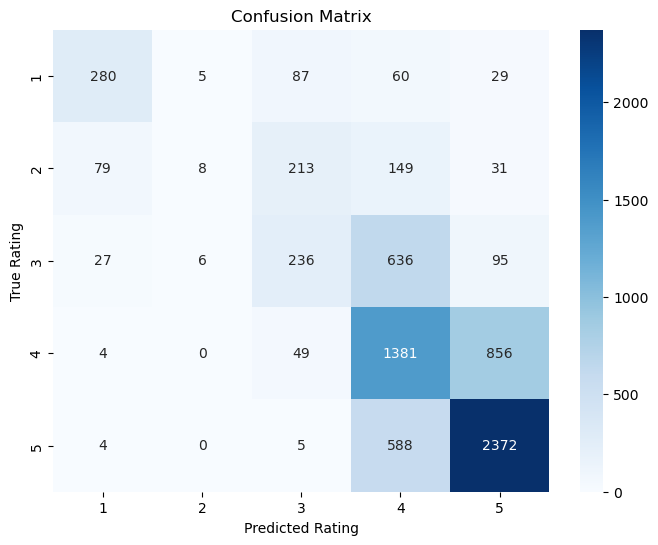

In [204]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

y_pred_mnb = mnb.predict(X_test_vec)
mae = mean_absolute_error(y_test, y_pred_mnb)
acc = accuracy_score(y_test, y_pred_mnb)
weighted_f1 = f1_score(y_test, y_pred_mnb, average='weighted')
macro_f1 = f1_score(y_test, y_pred_mnb, average='macro')

print("Multinomial Naive Bayes:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"F1 macro score: {macro_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_mnb))

con_mat = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


In [205]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
# vectorizer = CountVectorizer(lowercase=True, token_pattern='[a-zA-Z0-9@#$%_]{2,}', \
#                                  max_features=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Normal SVM:
Accuracy: 0.6325
F1 score: 0.6270
F1 macro score: 0.5621
Mean Absolute Error: 0.4144
              precision    recall  f1-score   support

           1       0.67      0.67      0.67       461
           2       0.41      0.27      0.33       480
           3       0.52      0.45      0.48      1000
           4       0.56      0.60      0.58      2290
           5       0.74      0.77      0.76      2969

    accuracy                           0.63      7200
   macro avg       0.58      0.55      0.56      7200
weighted avg       0.63      0.63      0.63      7200



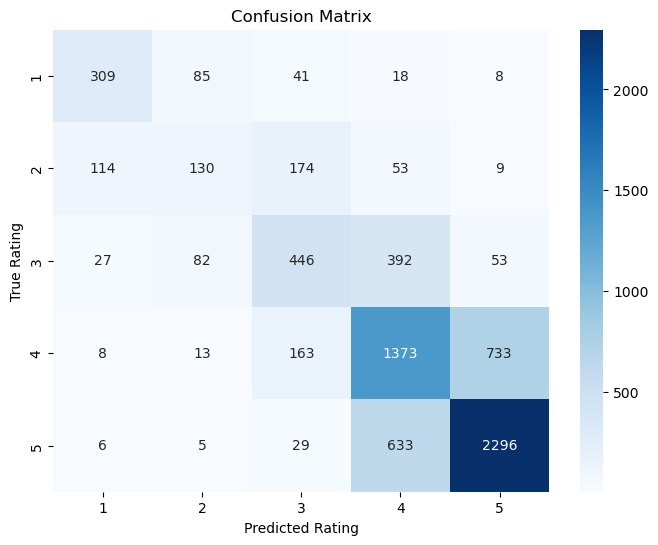

In [206]:
from sklearn.svm import LinearSVC

svm = SVC(kernel='linear', C=1)
svm.fit(X_train_vec, y_train)

y_pred_svm = svm.predict(X_test_vec)
mae = mean_absolute_error(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')
macro_f1 = f1_score(y_test, y_pred_svm, average='macro')

print("Normal SVM:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"F1 macro score: {macro_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_svm))

con_mat = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


Normal Logistic Regression:
Accuracy: 0.6301
F1 score: 0.6250
F1 Macro: 0.5628
Mean Absolute Error: 0.4269
              precision    recall  f1-score   support

           1       0.62      0.73      0.67       461
           2       0.36      0.30      0.33       480
           3       0.51      0.49      0.50      1000
           4       0.59      0.53      0.56      2290
           5       0.73      0.79      0.76      2969

    accuracy                           0.63      7200
   macro avg       0.56      0.57      0.56      7200
weighted avg       0.62      0.63      0.62      7200



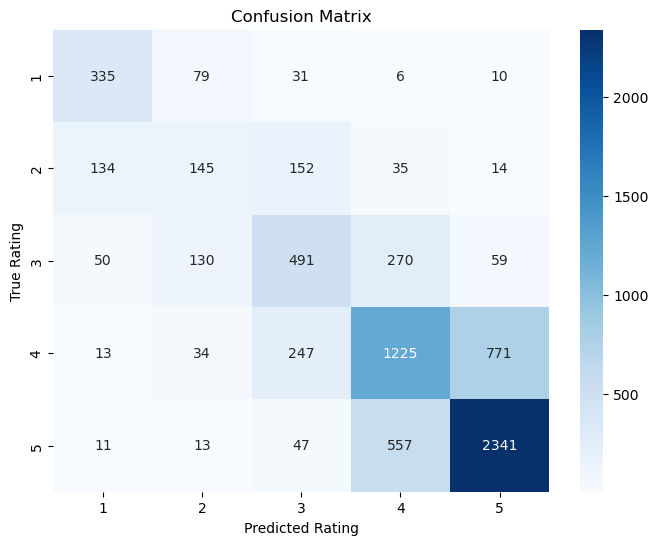

In [207]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=1.0, class_weight='balanced', 
                             solver='liblinear', penalty='l2',            
                             max_iter=10000, random_state=42
                             )

log_reg.fit(X_train_vec, y_train)

y_pred_lr = log_reg.predict(X_test_vec)
mae = mean_absolute_error(y_test, y_pred_lr)
acc = accuracy_score(y_test, y_pred_lr)
weighted_f1 = f1_score(y_test, y_pred_lr, average='weighted')
macro_f1 = f1_score(y_test, y_pred_lr, average='macro')

print("Normal Logistic Regression:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"F1 Macro: {macro_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

print(classification_report(y_test, y_pred_lr))

con_mat = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


Cross-Validation Scores: [0.60172165 0.58550097 0.60041583 0.60038937 0.6003871 ]
Mean Stratified CV Score: 0.5977 (±0.0061)
SVM with stratified K-fold validation:
Accuracy: 0.6146
F1 weighted score: 0.6009
F1 Macro: 0.5268
Mean Absolute Error: 0.4564
              precision    recall  f1-score   support

           1       0.65      0.67      0.66       461
           2       0.41      0.18      0.25       480
           3       0.51      0.37      0.43      1000
           4       0.53      0.56      0.54      2290
           5       0.71      0.80      0.75      2969

    accuracy                           0.61      7200
   macro avg       0.56      0.52      0.53      7200
weighted avg       0.60      0.61      0.60      7200



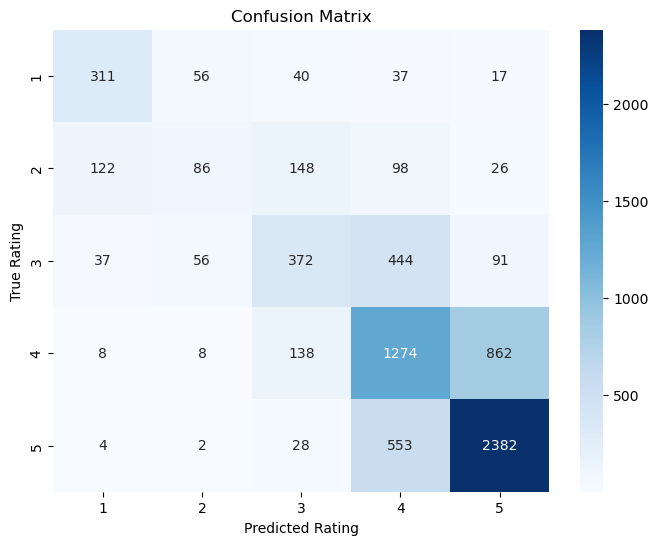

In [208]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=80000)),
    ('model', CalibratedClassifierCV(LinearSVC(C=1, class_weight='balanced')))
])

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_cv_scores = cross_val_score(pipeline, lem_train_data["lemmatized_text"], 
                                       lem_train_data["overall"], 
                                       cv=stratified_kfold, scoring='f1_weighted')

print(f"Cross-Validation Scores: {stratified_cv_scores}")
print(f"Mean Stratified CV Score: {np.mean(stratified_cv_scores):.4f} (±{np.std(stratified_cv_scores):.4f})")

pipeline.fit(X_train, y_train)

y_pred_svm = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')
macro_f1 = f1_score(y_test,y_pred_svm, average='macro' )

print("SVM with stratified K-fold validation:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 weighted score: {weighted_f1:.4f}")
print(f"F1 Macro: {macro_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_svm))

con_mat = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


Cross-Validation Scores (Stratified): [0.63208333 0.624375   0.626875   0.6225     0.63513232]
Mean Stratified CV Score: 0.6282 (±0.0047)

Test Set Evaluation:
Accuracy: 0.6301
f1 score: 0.6250

Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.73      0.67       461
           2       0.36      0.30      0.33       480
           3       0.51      0.49      0.50      1000
           4       0.59      0.53      0.56      2290
           5       0.73      0.79      0.76      2969

    accuracy                           0.63      7200
   macro avg       0.56      0.57      0.56      7200
weighted avg       0.62      0.63      0.62      7200



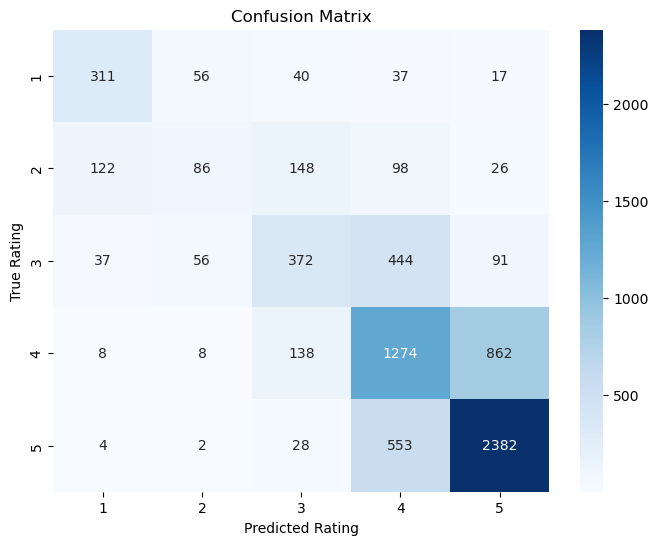

In [209]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), max_features=50000)),
    ('model', LogisticRegression(C=1.0, class_weight='balanced', 
                             solver='liblinear', penalty='l2',            
                             max_iter=10000, random_state=42
                             ))
])

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_cv_scores = cross_val_score(pipeline, lem_train_data["lemmatized_text"], 
                                       lem_train_data["overall"], 
                                       cv=stratified_kfold, scoring='accuracy')

print(f"Cross-Validation Scores (Stratified): {stratified_cv_scores}")
print(f"Mean Stratified CV Score: {np.mean(stratified_cv_scores):.4f} (±{np.std(stratified_cv_scores):.4f})")

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1 score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

Random Forest:
Accuracy: 0.5574
F1 score: 0.5080
Mean Absolute Error: 0.6078
              precision    recall  f1-score   support

           1       0.69      0.52      0.59       461
           2       0.31      0.01      0.02       480
           3       0.44      0.08      0.14      1000
           4       0.45      0.52      0.48      2290
           5       0.63      0.84      0.72      2969

    accuracy                           0.56      7200
   macro avg       0.50      0.39      0.39      7200
weighted avg       0.53      0.56      0.51      7200



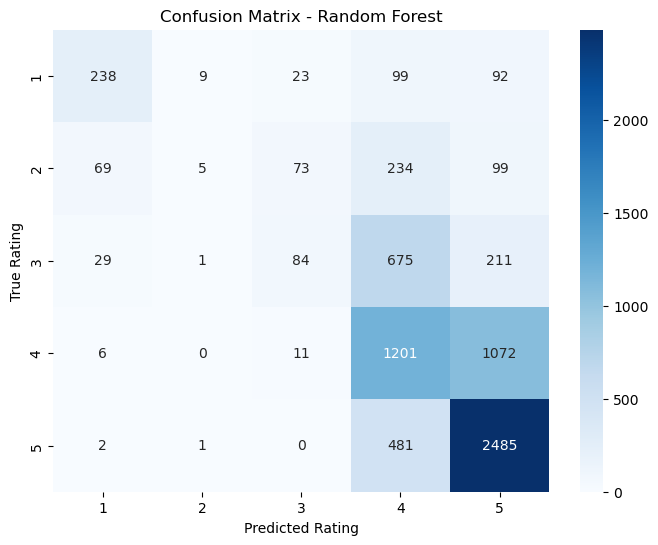

In [210]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
    ('model', RandomForestClassifier(
        n_estimators=100,     
        max_depth=None,       
        min_samples_split=2,  
        random_state=42       
    ))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
weighted_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_rf))

con_mat = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(1, 6),
           yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [211]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# !python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md')

X_train, X_test, y_train, y_test = train_test_split(
    lem_train_data["lemmatized_text"], 
    lem_train_data["overall"], 
    test_size=0.3, 
    random_state=42
)
print(len(X_train), len(X_test))

16799 7200


Random Forest with word vectors:
Accuracy: 0.4992
F1 score: 0.4615
Mean Absolute Error: 0.6907
              precision    recall  f1-score   support

           1       0.53      0.44      0.48       461
           2       0.29      0.06      0.10       480
           3       0.30      0.09      0.14      1000
           4       0.41      0.43      0.42      2290
           5       0.58      0.77      0.66      2969

    accuracy                           0.50      7200
   macro avg       0.42      0.36      0.36      7200
weighted avg       0.46      0.50      0.46      7200



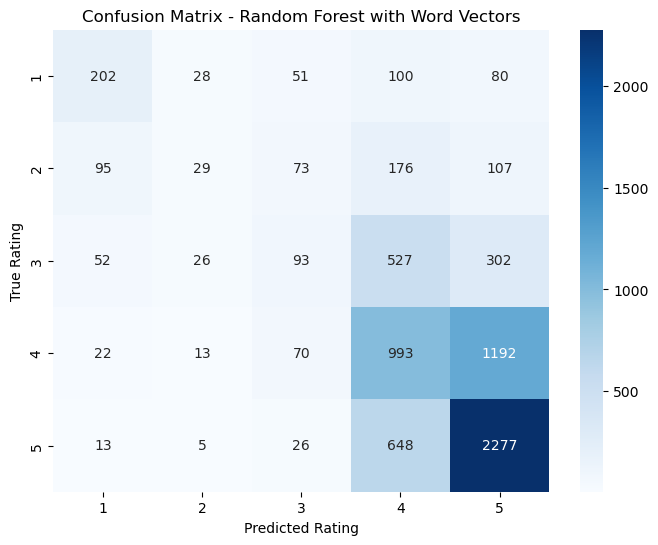

In [213]:
from sklearn.base import BaseEstimator, TransformerMixin

class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model='en_core_web_md'):
        self.model = model
        self.nlp = spacy.load(model)
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.nlp(doc).vector for doc in X])

pipeline_rf_vectors = Pipeline([
    ('word_vectors', SpacyVectorTransformer(model='en_core_web_md')),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ))
])

pipeline_rf_vectors.fit(X_train, y_train)

y_pred_rf = pipeline_rf_vectors.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
weighted_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest with word vectors:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_rf))

con_mat = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(1, 6),
           yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix - Random Forest with Word Vectors')
plt.show()

### 4. Experiment with VADER sentiment lexicon

In [214]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sentiment = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    score = sentiment.polarity_scores(text)
    return score['compound']

lem_train_data.loc[:, 'vader_score'] = lem_train_data['lemmatized_text'].apply(sentiment_scores)
lem_train_data


/tmp/ipykernel_202462/1105961701.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lem_train_data.loc[:, 'vader_score'] = lem_train_data['lemmatized_text'].apply(sentiment_scores)


,overall,clean_title,lemmatized_text,vader_score
0,1,horrible experience,horrible experience first get room book pay di...,0.7717
1,1,stay away,stay away find racist graffiti room request ch...,-0.8225
2,4,great location and service,great location service close union square hote...,0.8360
3,2,I will never go back here again,never go back bad vibe place moment walk main ...,0.9676
4,1,rip off our visa card after departure,rip visa card departure receive final bill lea...,0.6124
...,...,...,...,...
23994,4,pleasant stay with good location,pleasant stay good location stay one night vis...,0.9774
23995,3,hit or miss some thing need attention,hit miss thing need attention spend two night ...,0.9771
23996,5,good breakfast,good breakfast room fairly large pretty quiet ...,0.8689
23997,4,deserve a high rating,deserve high rating great start stay check 2hr...,0.9618


In [215]:
def vader_classification(score):
    if score >= 0.7:
        return 5
    elif score > 0.3:
        return 4
    elif score > -0.3:
        return 3
    elif score >= -0.7:
        return 2
    else:
        return 1
    
lem_train_data.loc[:, 'vader_rating'] = lem_train_data['vader_score'].apply(vader_classification)
lem_train_data['vader_rating']
lem_train_data.loc[:, 'rating_discrepancy'] = abs(lem_train_data['overall'] - lem_train_data['vader_rating'])
lem_train_data

/tmp/ipykernel_202462/2934852324.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lem_train_data.loc[:, 'vader_rating'] = lem_train_data['vader_score'].apply(vader_classification)
/tmp/ipykernel_202462/2934852324.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lem_train_data.loc[:, 'rating_discrepancy'] = abs(lem_train_data['overall'] - lem_train_data['vader_rating'])


,overall,clean_title,lemmatized_text,vader_score,vader_rating,rating_discrepancy
0,1,horrible experience,horrible experience first get room book pay di...,0.7717,5,4
1,1,stay away,stay away find racist graffiti room request ch...,-0.8225,1,0
2,4,great location and service,great location service close union square hote...,0.8360,5,1
3,2,I will never go back here again,never go back bad vibe place moment walk main ...,0.9676,5,3
4,1,rip off our visa card after departure,rip visa card departure receive final bill lea...,0.6124,4,3
...,...,...,...,...,...,...
23994,4,pleasant stay with good location,pleasant stay good location stay one night vis...,0.9774,5,1
23995,3,hit or miss some thing need attention,hit miss thing need attention spend two night ...,0.9771,5,2
23996,5,good breakfast,good breakfast room fairly large pretty quiet ...,0.8689,5,0
23997,4,deserve a high rating,deserve high rating great start stay check 2hr...,0.9618,5,1


In [216]:
mean_discrepancy = lem_train_data['rating_discrepancy'].mean()
print(f"The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: {mean_discrepancy:.4f}")

The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: 0.8494


accuracy: 0.4416
precision: 0.3465
recall: 0.4416
f1_weighted: 0.3147
              precision    recall  f1-score   support

           1       0.69      0.28      0.40      1557
           2       0.28      0.08      0.13      1611
           3       0.25      0.05      0.08      3287
           4       0.19      0.02      0.04      7720
           5       0.46      0.98      0.62      9824

    accuracy                           0.44     23999
   macro avg       0.37      0.28      0.26     23999
weighted avg       0.35      0.44      0.31     23999



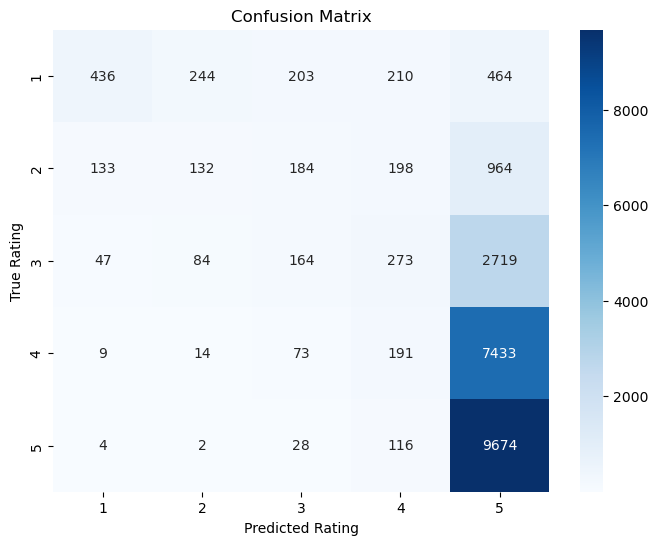

In [217]:
y_true, y_pred = lem_train_data['overall'], lem_train_data['vader_rating']

accuracy = accuracy_score(y_true, y_pred)
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f'accuracy: {accuracy:.4f}')
print(f'precision: {precision_weighted:.4f}')
print(f'recall: {recall_weighted:.4f}')
print(f'f1_weighted: {f1_weighted:.4f}')

print(classification_report(y_true, y_pred))

con_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

### Appendix